In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR,ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch import Tensor



import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, roc_auc_score,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay,roc_curve
import math as m
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm

### Dataset customisée par entraîner un modèle d'auto encodeur

In [ ]:
class AE_Dataset(Dataset):

    """Cette classe à été créée afin de créer facilement un DataLoader de pytorch
    """
    def __init__(self, data):

        super(AE_Dataset,self).__init__()

        #La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
        #de l'auto encodeur c'est de reconstituer la donnée initiale

        self.data = np.copy(data)
        self.targets = np.copy(data)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return torch.tensor(self.data[index],dtype=torch.float32), torch.tensor(self.targets[index],dtype=torch.float32)

In [ ]:
def confusin_matrix_display(ytest,ypred):
    metrics.ConfusionMatrixDisplay(confusion_matrix(ytest,ypred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

def precision_recall_display(ytest, ypred):
    precision, recall, _ = precision_recall_curve(ytest, ypred)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Precision_Recall_Curve")
    plt.show()

def roc_curve_disolay(ytest, ypred):
    fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    print(f"roc_auc {roc_auc}")
    display.plot()
    plt.title("ROC_Curve")
    plt.show()

def scores_(ytest,ypred):
    df=pd.DataFrame({"f1_score" : [f1_score(ytest,ypred)],
                     "accuracy_score" : [accuracy_score(ytest,ypred)],
                     "precision_score" : [precision_score(ytest,ypred)],
                     "recall_score" : [recall_score(ytest,ypred)]
    })
    print(df)
    return df

def draw_anomaly(y_true,score, seuil):
    groupDF=pd.DataFrame({
        "error":score,
        "true":y_true
    }).groupby('true')
    fig, ax=plt.subplots(figsize=(12,8))

    for name, group in groupDF:
        ax.plot(group.index,group.error,marker='x' if name==1 else 'o', linestyle='',color='r' if name==1 else 'g',label="anomalie" if name==1 else "normal")
    ax.hlines(seuil,ax.get_xlim()[0],ax.get_xlim()[1], colors ="b", zorder=100,label="Seuil")
    ax.legend()
    
    plt.title("Anomalies")
    plt.xlabel("Données")
    plt.ylabel("Score(erreur)")
    plt.show()


def evaluation(ytrue,ypred):
    confusin_matrix_display(ytrue,ypred)
    # precision_recall_display(ytrue, ypred)
    # roc_curve_disolay(ytrue, ypred)
    scores_(ytrue,ypred)

def transform_target(target):
    """Args:
        target: np.ndarry or pd.DataFrame
    """
    n=target.shape[0]
    if isinstance(target,np.ndarray):
        target[target==1]=-1
        target[target==0]=1

    elif isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=-1
        target[target==0]=1
    return target


def inverse_transform_target(target):
    n=target.shape[0]
    if isinstance(target,pd.DataFrame) or isinstance(target,pd.Series):
        target[target==1]=0
        target[target==-1]=1

    elif isinstance(target,np.ndarray):
        target[target==1]=0
        target[target==-1]=1
    return target

In [ ]:
class CustomDataset:

    def __init__(self, file_path, scaler,test_size=0.15, random_state=42):

        self.file_path = file_path
        self.test_size = test_size
        self.random_state = random_state
        self.scaler = scaler

        self.data = None
        self.target = None

        # Chargement et prétraitement de la donnée
        self._load_data()
        self._preprocess_data()
        self._split_data()

        self.xtrain = self._xtrain # ce sont uniquement les données normales quui seront entraînées avec l'auto encoder
        self.ytrain = self.xtrain # La target d'un auto encoder est lui le donnée initial car n'oublions pas que l'objectif
                                # de l'auto encodeur c'est de reconstituer la donnée initiale

        # Par contre les données de test devront à la fois contenir les données normales et les données anormales
        #Ainsi les données de test seront la concatenation entre les données normales reservées pour le test et les données contenant que des 1

        # print(f"type(self.data.shape) {self.data.shape}")
        # print(f"type(self.self.shape) {self.target.shape}")
        # print(f"type(self.data[self.target==1]) {self.target==1}")
        # print(f"type(self.data[self.target==1]) {self.data[self.target==1]}")
        self.xtest = pd.concat([self._xtest, self.data[self.target==1]], axis=0)
        self.ytest = pd.concat([self._ytest, self.target[self.target==1]], axis=0)

        self.xtest.reset_index(drop=True, inplace=True)
        self.ytest.reset_index(drop=True, inplace=True)

        # Note : ytrain utilisé comme target lors de l'entraînement n'est le même format que ytest utilisé lors de la prédiction
        # ytrain =xtrain alors que ytest =target (labels)(0 pour donnée normale et 1 pour donnée anormale)


    def get_scaler(self):
        return self.scaler

    def _load_data(self):
        self.data = pd.read_csv(self.file_path)

        self.data.drop_duplicates(keep="last", inplace=True)
        self.target = self.data["Class"]
        self.data.drop(["Class","Time"], axis=1,inplace=True)


    def _preprocess_data(self):

        # Avec un modèle de réseaux de neurones profond, l'on n'est pas obligé de pré-traiter la donnée
        if self.scaler is not None:

            data_scaled_array = self.scaler.fit_transform(self.data)
            # self.data['Amount']=self.scaler.fit_transform(self.data['Amount'].values.reshape(self.data.shape[0],-1))

            #Il est impératif d'ajouter l'argument index lors de la créaction d'un dataframe à partir d'un numpy array
            # Dans notre cas, data_scaled_array est un tableau numpy. si l'argument "index" n'est pas ajouté alors l'index par défaut sera
            # RangeIndex. Le RangeIndex est incompatible avec la Index. Par exemple il sera impossible de concater deux dataframes
            # Ou un dataframe et une serie dont l'un possède Index et l'autre RangeIndex
            self.data = pd.DataFrame(data_scaled_array, columns=self.data.columns,index=self.data.index)


    def _split_data(self):

        self._xtrain, self._xtest, self._ytrain, self._ytest = train_test_split(
            self.data, self.target, test_size=self.test_size, random_state=self.random_state, shuffle=True)

    def get_train_data(self):
        return self.xtrain, self.ytrain

    def get_test_data(self):
        return self.xtest, self.ytest

## Encoder Layer

In [ ]:
class Encoder(nn.Module):

    def __init__(self,input_size: int,dropout: float) -> None:

        super(Encoder,self).__init__()

        latent_size=m.ceil(input_size/6)
        self.latent=latent_size
        
        self.fc1=nn.Linear(in_features=input_size,out_features=5 * latent_size)
        self.residual1=nn.Linear(in_features=input_size,out_features=4* latent_size)
        self.layer_norm1=nn.BatchNorm1d(5 *latent_size)
        self.relu1=nn.ReLU()
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=5* latent_size,out_features=4* latent_size)
        self.layer_norm2=nn.BatchNorm1d(4* latent_size)
        self.relu2=nn.ReLU()
        self.residual2=nn.Linear(in_features=4* latent_size,out_features=latent_size +5)
        self.fc3=nn.Linear(in_features=4* latent_size,out_features=3* latent_size)
        self.layer_norm3=nn.BatchNorm1d(3* latent_size)
        self.relu3=nn.ReLU()
        self.dropout2=nn.Dropout(dropout)
        self.fc4=nn.Linear(in_features=3*latent_size,out_features=latent_size +5)



    def forward(self,inputs: Tensor) -> Tensor:

        x=self.fc1(inputs)
        x=self.layer_norm1(x)
        x=self.relu1(x)
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x=self.fc2(x)+residual1
        x=self.layer_norm2(x)
        x= self.relu2(x)
        residual2=self.residual2(x)
        x=self.fc3(x)
        x=self.layer_norm3(x)
        x= self.relu3(x)
        x=self.dropout2(x)
        x=self=self.fc4(x) + residual2

        return x


## Decoder Layers

In [ ]:
class Decoder(nn.Module):

    def __init__(self, output_size: int,dropout: float) -> None:

        super(Decoder,self).__init__()

        latent_size=m.ceil(output_size/6)
        self.latent=latent_size
        
        self.fc1=nn.Linear(in_features=latent_size +5,out_features=latent_size*3)
        self.residual1=nn.Linear(in_features=latent_size +5,out_features=4* latent_size)
        self.layer_norm3=nn.LayerNorm(3*latent_size)
        self.relu1=nn.LeakyReLU(0.1)
        self.dropout1=nn.Dropout(dropout)
        self.fc2=nn.Linear(in_features=3* latent_size,out_features=4*latent_size)
        self.layer_norm4=nn.LayerNorm(4*latent_size)
        self.relu2=nn.LeakyReLU(0.1)
        self.residual2=nn.Linear(in_features=4*latent_size,out_features=output_size)
        self.fc3=nn.Linear(in_features=4*latent_size,out_features=5*latent_size)
        self.layer_norm5=nn.LayerNorm(5 *latent_size)
        self.relu3=nn.LeakyReLU(0.1)
        self.dropout2=nn.Dropout(dropout)

        self.fc4=nn.Linear(in_features=5 *latent_size,out_features=output_size)




    def forward(self,inputs: Tensor) -> Tensor:
        x=self.fc1(inputs)
        x=self.layer_norm3(x)
        x=self.relu1(x)
        residual1=self.residual1(inputs)
        x=self.dropout1(x)
        x=self.fc2(x) +residual1
        x=self.layer_norm4(x)
        x= self.relu2(x)
        residual2=self.residual2(x)
        x=self.fc3(x)
        x=self.layer_norm5(x)
        x= self.relu3(x)
        x=self.dropout2(x)
        x=self=self.fc4(x) +residual2

        return x

In [ ]:
"""RuntimeError: The size of tensor a (196) must match the size of tensor b (29) at non-singleton dimension 1"""

'RuntimeError: The size of tensor a (196) must match the size of tensor b (29) at non-singleton dimension 1'

## AutoEncoder

In [ ]:
class AutoEncoder(nn.Module):

    def __init__(self,input_size: int,output_size: int,contamination: float=0.5,dropout: float=0.1,device: str="cuda") -> None:

        super(AutoEncoder,self).__init__()

        self.encoder=Encoder(input_size=input_size,dropout=dropout)
        self.latent=None
        self.decoder=Decoder(output_size=output_size,dropout=dropout)
        self.offset=contamination

        self.device= torch.device("cuda") if device=="cuda" else torch.device("cpu")

        self.is_fitted=False

        self.train_curve=[]
        self.val_curve=[]



    def forward(self,inputs: Tensor) -> Tensor:
        x=self.encoder(inputs)
        self.latent=x
        x=self.decoder(x)

        return x


    def train_one_epoch(self,train_loader:DataLoader,optimizer,scheduler,loss_fn):

        """The function is use to train one epoch of the model
            Args:
                optimizer      : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function  : The loss function to use during the model training. CrossEntropyLoss and MSELoss are very often use for respectively
                                classification and regression problem
                train_loader   : A torch DataLoader which is use to iterate through the data during train step

            Return : The last loss value on the train_loader

        """
        running_loss = 0.0
        last_loss = 0.0

        self.loss_fn=loss_fn

        for batch_index, batch in enumerate(train_loader):

            optimizer.zero_grad() # Putting gradient to zero in order to accumulate upcoming gradient


            data,target=batch[0].to(self.device),batch[1].to(self.device)

            outputs=self.forward(data) # Making prediction

            loss=loss_fn(outputs.to(self.device),target) # Computing the loss
            loss.backward() # Computing the gradient

            running_loss+=loss.item() # Accumulation loss through one epoch

            optimizer.step() # Updating weights

            if batch_index%100==99:
                last_loss=running_loss/100 # Computing loss per batch
                # print("batch {} loss {}".format(batch_index+1,last_loss))
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print("SGD lr %.8f -> %.8f" % (before_lr, after_lr))
        return last_loss


    def validation_one_epoch(self,validation_loader,loss_fn):

        """The function is used to train one epoch of the model
            Args:
                optimizer       : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                loss_function   : The loss function to use during the model validation. Same as the training one
                val_loader      : A torch DataLoader which is use to iterate through the data during validation step

            Return : The last loss value on the val_loader

        """
        avg_vloss = 0.
        running_loss=0.
        with torch.no_grad() :
            for batch in validation_loader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self.forward(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss

                running_loss+=loss.item() # Accumulation loss through one epoch

        avg_vloss=running_loss/len(validation_loader)

        return avg_vloss




    def evaluation(self,y_test,predictions,metric="mse"):
        # Evaluate the model
        if metric=="mse" :print("Mean Squared Error (MSE):", mean_squared_error(y_test, predictions))
        elif metric =="mae" :print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predictions))

    def predict(self, dataloader,contamination):
        contaminationn= contamination if contamination != self.offset  else self.offset
        assert self.is_fitted==True, "Le modèle n'est pas encore entraîné donc ne peut pas faire de prédiction"
        return self.decision_function(dataloader,contaminationn)


    def decision_function(self,dataloader: DataLoader, contamination):

        dataframe=self.compute_score_sample(dataloader)
        dataframe.loc[-dataframe["score_sample"] < (-dataframe["score_sample"]).quantile(contamination), "label"] = -1

        return dataframe['label']

    def score_sample(self,dataloader: DataLoader,loss_fn=nn.MSELoss(reduction='none')):

        dataframe=self.compute_score_sample(dataloader)

        return dataframe["score_sample"]

    def compute_score_sample(self,dataloader: DataLoader,loss_fn=nn.MSELoss(reduction='none')):

        assert loss_fn.reduction=='none',"La fonction pour le calcul des erreurs de reconstitution ne possède pas les bonne argument"

        reconstition_errors=[]
        with torch.no_grad() :
            for batch in dataloader:

                data,target=batch[0].to(self.device),batch[1].to(self.device)
                outputs=self.forward(data) # Making prediction

                loss=loss_fn(outputs,target) # Computing the loss

                for item in loss:
                    reconstition_errors.append(torch.sum(item).item())


        dataframe=pd.DataFrame({
            "score_sample" : reconstition_errors,
            "label" :[1 for _ in range(len(reconstition_errors))]
        })

        return dataframe


    def fit(self,train_loader,validation_loader,optimizer,scheduler,loss_fn,epochs=100,device="cuda"):
        """The function is used to train the model through many epochs
            Args:
                optimizer             : The optimizer algorithm to be use. SDG or Adam are used in most of cases
                train_loader          : A torch DataLoader which is use to iterate through the data during train step
                loss_function         : The loss function to use during the model validation. Same as the training one
                validataion_loader    : A torch DataLoader which is use to iterate through the data during validation step

            Return : No return

        """
        self.to(self.device)
        best_avg_vloss=1_000_000_000
        for epoch in range(epochs):
            # print("\n")
            print("EPOCHS : {}".format(epoch +1))
            self.train(True) # Activate training mode
            avg_loss=self.train_one_epoch(train_loader,optimizer,scheduler,loss_fn) # training the model on an epoch

            self.eval() # Setting the evaluation mode so that no gradient will be compute, that will save forward pass time
            avg_vloss=self.validation_one_epoch(validation_loader,loss_fn) # Evalution the model after one epoch
            print(f"Loss {avg_loss} vs Validation_loss  {avg_vloss}")
            self.train_curve.append(avg_loss)
            self.val_curve.append(avg_vloss)

            if avg_vloss < best_avg_vloss :
                best_avg_vloss=avg_vloss
                #model_path='/home/dah/timeSeries/time_series_forcasting/models/model_{}'.format(datetime.now().strftime('%Y%m%d_%H%'))
                #torch.save(self.cpu().state_dict(),model_path)
                self.to(self.device)
                self.to(self.device)
        self.is_fitted=True

        return {
            "train":self.train_curve,
            "val":self.val_curve
        }


In [9]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
# file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv"
file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=AutoEncoder(input_size=29,output_size=29,contamination=0.02,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
epochs=100
optimizer=optim.SGD(lr=1e-2, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-1, end_factor=1e-5, total_iters=epochs) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.MSELoss() # La fonction de perte

history=model.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=epochs)#Entraînement du modèle



EPOCHS : 1
SGD lr 0.00100000 -> 0.00099000
Loss 1.1152766116522252 vs Validation_loss  0.0026680024146110157
EPOCHS : 2
SGD lr 0.00099000 -> 0.00098000
Loss 0.14147814450785517 vs Validation_loss  0.002186178389793222
EPOCHS : 3
SGD lr 0.00098000 -> 0.00097000
Loss 0.08722021415363997 vs Validation_loss  0.00205376501288503
EPOCHS : 4
SGD lr 0.00097000 -> 0.00096000
Loss 0.07151728590484709 vs Validation_loss  0.001991908912622992
EPOCHS : 5
SGD lr 0.00096000 -> 0.00095001
Loss 0.06396717474563048 vs Validation_loss  0.0019561618454506592
EPOCHS : 6
SGD lr 0.00095001 -> 0.00094001
Loss 0.059405546812340615 vs Validation_loss  0.0019269548446468215
EPOCHS : 7
SGD lr 0.00094001 -> 0.00093001
Loss 0.05617330674664117 vs Validation_loss  0.00190292641659095
EPOCHS : 8
SGD lr 0.00093001 -> 0.00092001
Loss 0.05389875378459692 vs Validation_loss  0.001886175933324184
EPOCHS : 9
SGD lr 0.00092001 -> 0.00091001
Loss 0.051990037558134646 vs Validation_loss  0.0018685331123882774
EPOCHS : 10
SGD 

### Visualisation des des learnings curves sur le jeu de données d'entraînement et de validation.
N'ayant pas trop de données alors nous avons choisi le jeu de données de test comme je de données de validation lors de l'entraînement<br>
Rappellons que notre jeu de données d'entraînement est uniquement constitué de données normales afin d'apprendre à reconstituer correctement ces derniers.<br>
Cependata le jeu de données de test est constitué à la fois des données normales et des données anormales. Les données anormales détectées par notre auto encodeur seront celles dont l'erreur de reconstitution est la plus élevée<br>
Si notres jeux de données de test contient par exemple 1.5 % de d'anomalies alors nous choisirons d'attribuer le label -1 aux 1.5 % de données ayant une haute erreur de reconstitution

### Courbes d'entrainement vs validation 

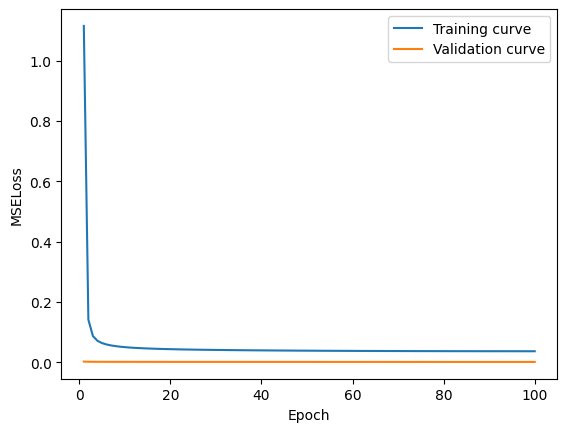

In [10]:
n=len(history['train'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['train'],label="Training curve")
plt.plot(epoch,history['val'],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")
plt.legend()

plt.show()

### Histogramme de scores d'anomalies

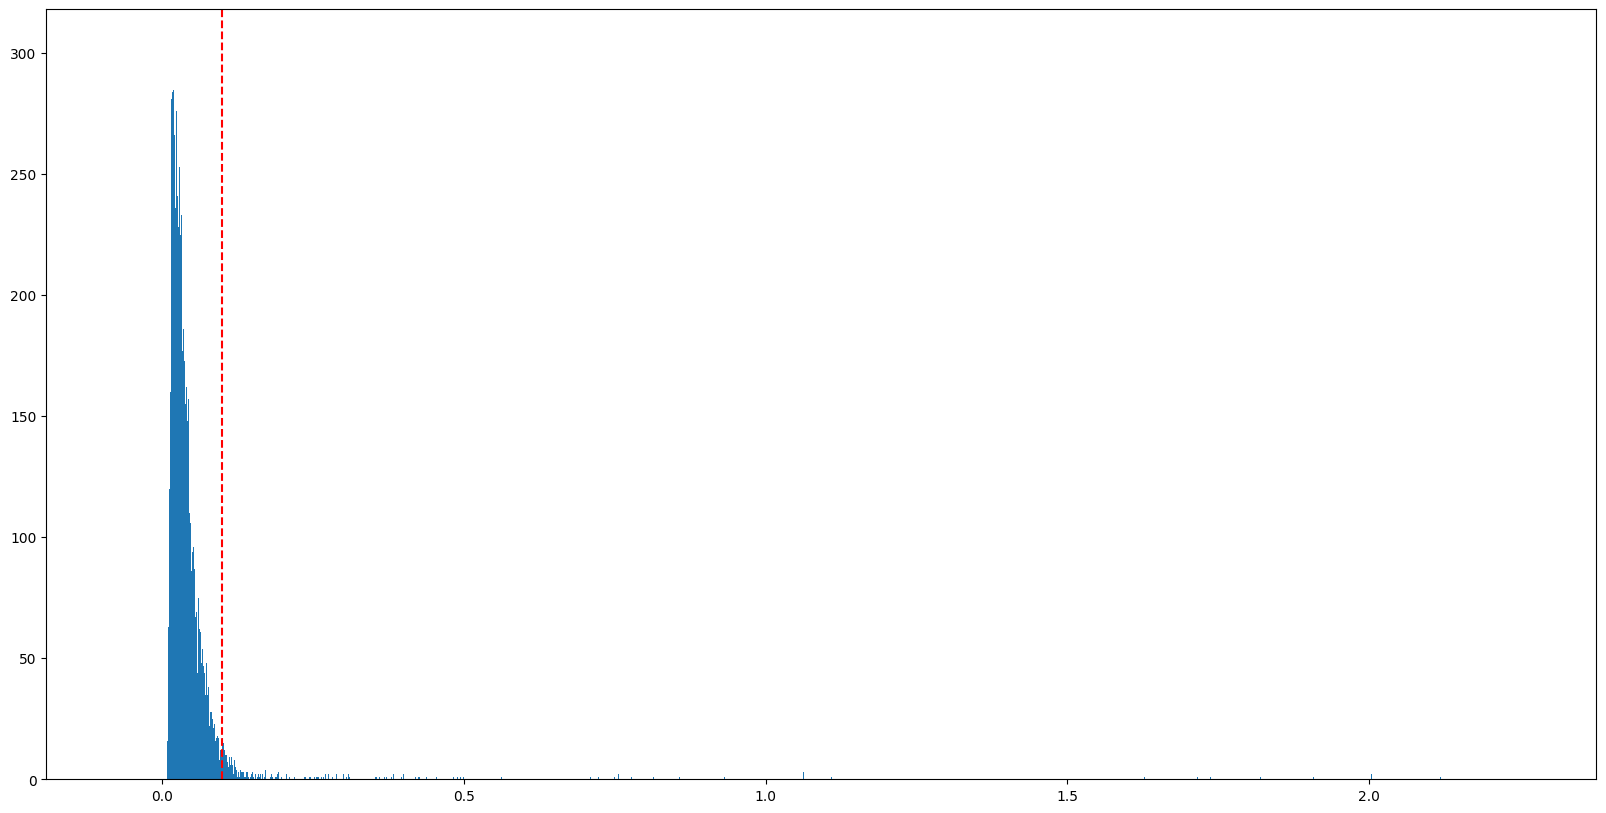

In [11]:
fig,ax=plt.subplots(figsize=(20,10))
score=model.score_sample(test_loader)
plt.xlim(min(score)-0.2, max(score))
score.hist(bins=10000,grid=False)

# Détermination de pourcentage de contamination
q=96
plt.axvline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')

plt.show()


### Boite à moustache des scores d'anomalies

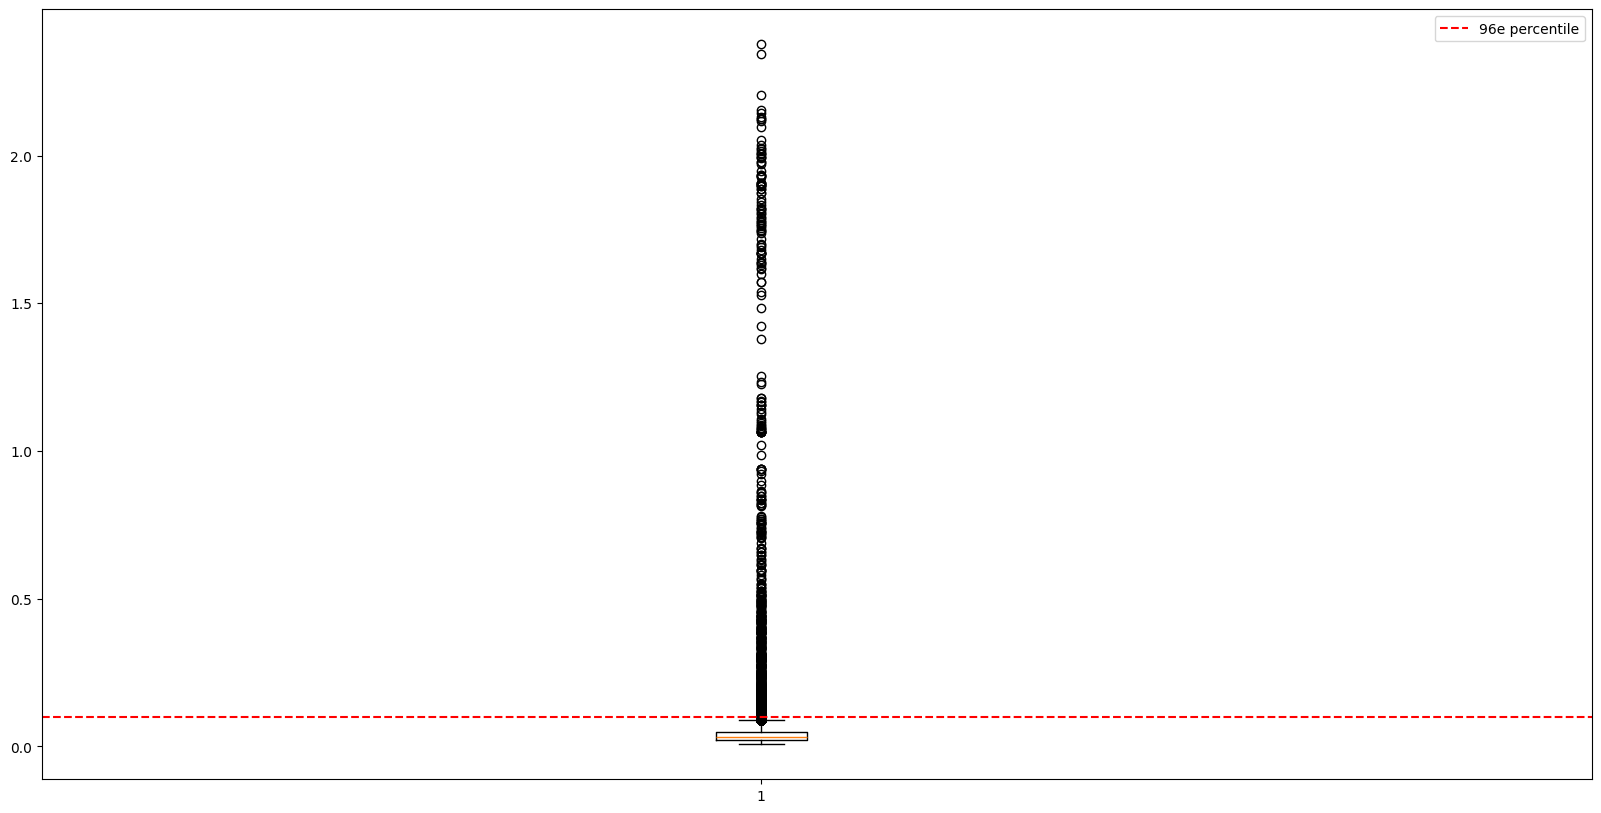

In [12]:
fig,ax=plt.subplots(figsize=(20,10))

plt.xlim(min(score)-0.2, max(score))
plt.boxplot(score)

# Détermination de pourcentage de contamination
q=96
plt.axhline(np.percentile(score, q=q), color='red', linestyle='--', label=f'{q}e percentile')
plt.legend()

plt.show()


### Visualisation des anomalies

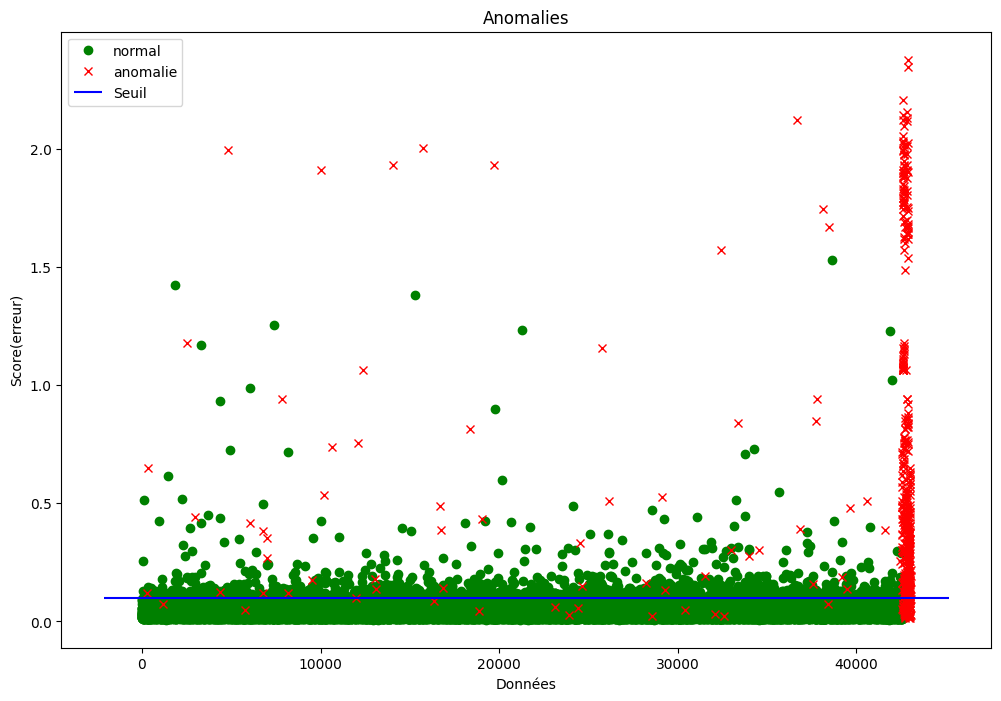

In [13]:
draw_anomaly(y_true=ytest,score=score, seuil=np.percentile(score, q=q))

### Prediction, matrice de confusion et autres metriques

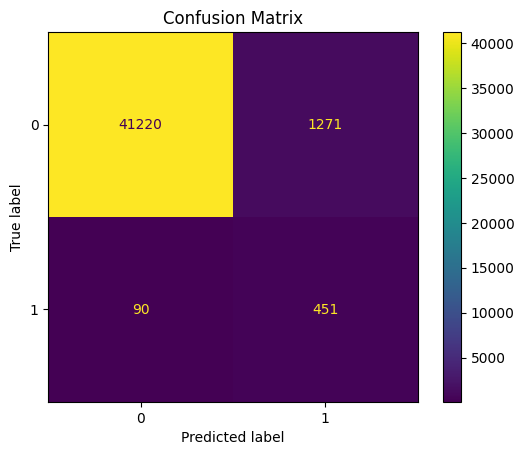

   f1_score  accuracy_score  precision_score  recall_score
0  0.398586        0.968372         0.261905      0.833641


In [14]:
ypred=model.predict(test_loader,contamination=0.04)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

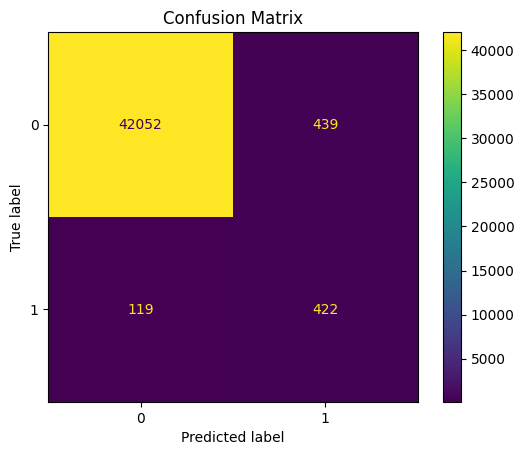

   f1_score  accuracy_score  precision_score  recall_score
0  0.601997        0.987033         0.490128      0.780037


In [15]:
ypred=model.predict(test_loader,contamination=0.02)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

### Commentaire
Grâce à la visualisation de la distribution des score d'anomalies on plus ou moins une idée du pourcence d'anomalie. Ici la **boite à moustache** nous indique qu'il y a **4%** d'anomalies. Cependant avec ce pourcentage le modèle se trompe beaucoup. On remarque qu'en prenant **2%** comme pourcentage d'anomalie le modèle se trompe moins. La détermination manuelle du pourcentage de score d'anomalie doit se faire alors avec beaucoup de précaution.

### Sauvegarde des résulatats

In [16]:
file_name="../resultats/auto_encodeur_simple.csv"

with open(file_name,"w",newline="") as csvfile:
    writer=csv.DictWriter(csvfile,fieldnames=["y_pred","score_anomalie","y_true"])
    writer.writeheader()
    n=score.shape[0]
    for i in range(n):
        row={
            "y_pred":ypred.iloc[i],
            "score_anomalie":score.iloc[i],
            "y_true":ytest.iloc[i],
        }
        writer.writerow(row)

### Courbes ROC-AUC

Auto encodeur simple: ROC AUC=0.947


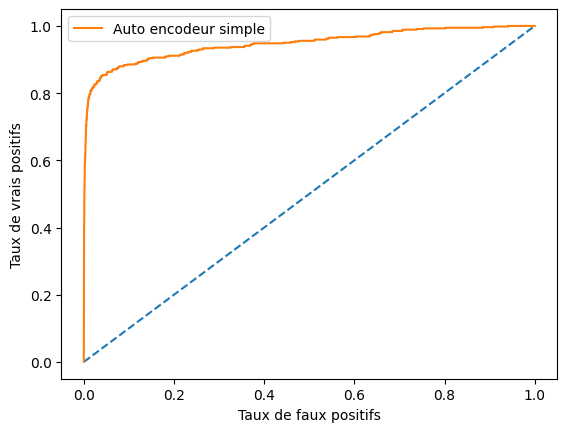

In [17]:
ns_probs = [0 for _ in range(len(ytest))]
# keep probabilities for the positive outcome only
np_score = score.tolist()
tensor=torch.tensor([np_score])
lr_probs = torch.softmax(tensor,dim=1,dtype=torch.float32).squeeze(0).numpy()

# calculate scores
ns_auc = roc_auc_score(ytest, ns_probs)
lr_auc = roc_auc_score(ytest, lr_probs)
# summarize scores

print('Auto encodeur simple: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(ytest, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, linestyle='-', label='Auto encodeur simple')
# axis labels
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
# show the legend
plt.legend()
# show the plot
plt.show()

#### Questions
1. Combien de couche utilisé dans notre couche d'encodeur ?
2. Quelle dimension pour la variable latente(la dimension de des donnée à la sortie des de la couche d'encodeur) ?
3. Quelle est la bonne initialisation des poids de notre réseaux (Quelle fonction utilisée) ?
4. Quel algo d'optimization utilisé (SGD, Adam, ...)?
5. Quelle fonction d'activation utilisée ?
6. Quelle pourcentage de contamination utilisé ?
7. Comment détecter des problèmes de vanishing ou exploding gradient ?

VISUALISATION TSNE

In [18]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['Class', 'Time'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/creditcard.csv'

In [ ]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [ ]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [ ]:
with open(src_path + "/X_embedded_creditcard.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open(src_path + "/embedded_index_creditcard.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Local Outlier Factor')

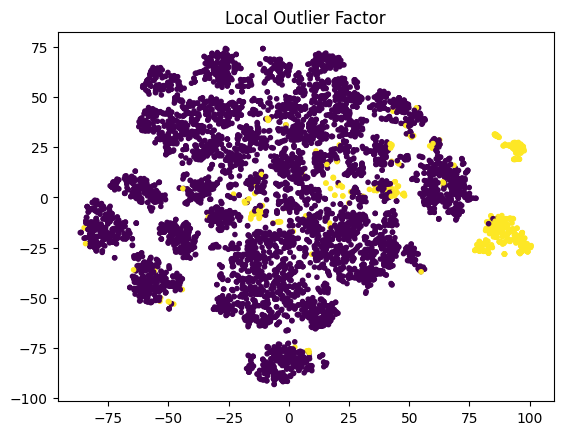

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Local Outlier Factor")

backdoor analysis

In [ ]:
# Reprodductibilité
torch.manual_seed(42)

# Creation Dataset
file_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv"
#file_path = "/home/dah/anomalie_detection/anomalie_detection/data/creditcard.csv"
dataset = CustomDataset(file_path=file_path,scaler=MinMaxScaler())

xtrain, ytrain = dataset.get_train_data()
xtest, ytest = dataset.get_test_data()


#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_train_dataset = AE_Dataset(xtrain)
pytorch_test_dataset = AE_Dataset(xtest)
train_loader=DataLoader(dataset=pytorch_train_dataset,batch_size=100)
test_loader=DataLoader(dataset=pytorch_test_dataset,batch_size=10)

#Creation de modeèle
model=AutoEncoder(input_size=196,latent_size=10,output_size=196,contamination=0.03,dropout=0.3,device="cuda")

#Creation des paramètres d'entrînement du modèle
optimizer=optim.SGD(lr=1e-1, params=model.parameters(),momentum=0.9) # Optimiseur
scheduler = LinearLR(optimizer, start_factor=1e-2, end_factor=1e-6, total_iters=100) # Permet de changer le learning rate au cours de l'apprentissage

                                                                                    #Plus on se rapproche du minimun plus le learning devient faible afin d'éviter les rebond et d'assurer la convergence vers le minimum
loss_fn=nn.MSELoss() # La fonction de perte

history=model.fit(train_loader,test_loader,optimizer,scheduler,loss_fn,epochs=200)#Entraînement du modèle

EPOCHS : 1
SGD lr 0.00100000 -> 0.00099000
Loss 0.7411279591917992 vs Validation_loss  0.03574762151014294
EPOCHS : 2
SGD lr 0.00099000 -> 0.00098000
Loss 0.22938967308029531 vs Validation_loss  0.018997939035465997
EPOCHS : 3
SGD lr 0.00098000 -> 0.00097000
Loss 0.15402434829622508 vs Validation_loss  0.015334672933516692
EPOCHS : 4
SGD lr 0.00097000 -> 0.00096000
Loss 0.13241151168942453 vs Validation_loss  0.014474708325737013
EPOCHS : 5
SGD lr 0.00096000 -> 0.00095001
Loss 0.12310051520355046 vs Validation_loss  0.014199341386756105
EPOCHS : 6
SGD lr 0.00095001 -> 0.00094001
Loss 0.1183829905744642 vs Validation_loss  0.014060463181882598
EPOCHS : 7
SGD lr 0.00094001 -> 0.00093001
Loss 0.11469777743332088 vs Validation_loss  0.013965036336350014
EPOCHS : 8
SGD lr 0.00093001 -> 0.00092001
Loss 0.11165504112839698 vs Validation_loss  0.013872575835191421
EPOCHS : 9
SGD lr 0.00092001 -> 0.00091001
Loss 0.10924100887030364 vs Validation_loss  0.013779839509200439
EPOCHS : 10
SGD lr 0.0

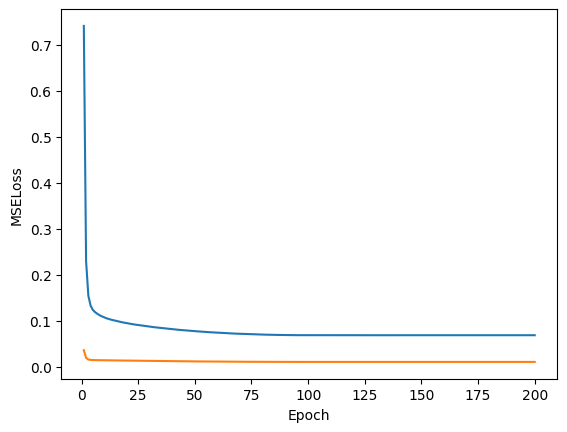

In [ ]:
n=len(history['train'])
epoch=[i for i in range(1,n+1)]
plt.plot(epoch,history['train'],label="Training curve")
plt.plot(epoch,history['val'],label="Validation curve")

plt.ylabel("MSELoss")
plt.xlabel("Epoch")

plt.show()

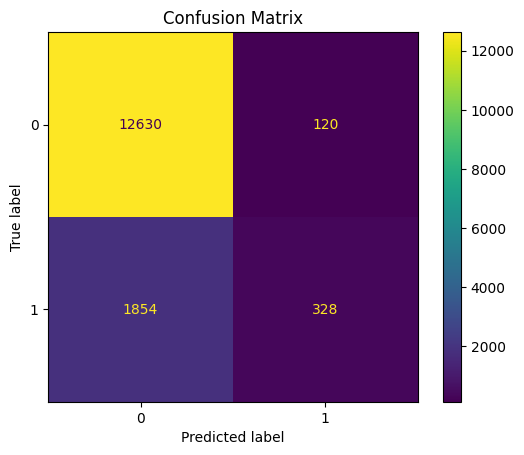

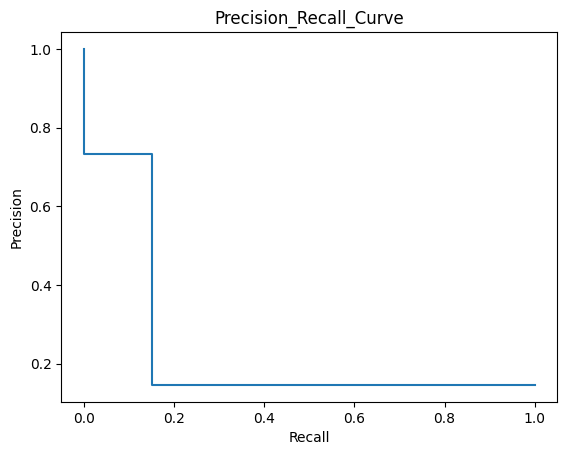

roc_auc 0.5704545209467838


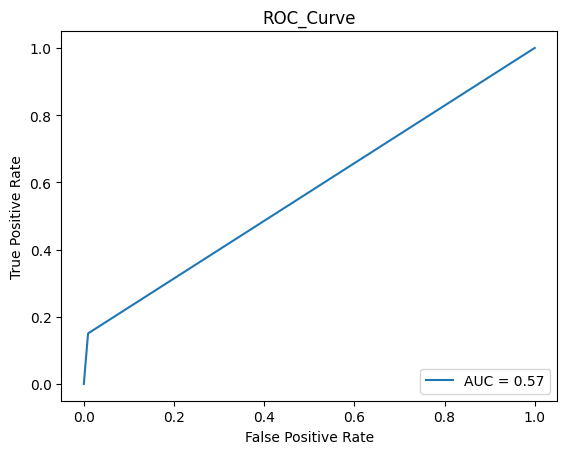

   f1_score  accuracy_score  precision_score  recall_score
0   0.24943        0.867801         0.732143      0.150321


In [ ]:
ypred=model.predict(test_loader)
ypred=inverse_transform_target(ypred)
evaluation(ytest,ypred)

Visualisation TSNE backdoor

In [ ]:
df = pd.read_csv('/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/data/UNSW_NB15_traintest_backdoor.csv', sep=',')
label = df.iloc[:, -1].copy()
df = df.drop(['class'], axis=1)
df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [ ]:
#Creation de DataLoader pytorch (Just un objet qui permet d'itérer plus faciler sur l'entièreté de la dataset)
pytorch_dataset = AE_Dataset(df)
loader=DataLoader(dataset=pytorch_dataset,batch_size=10)

In [ ]:
viz_y = model.predict(loader)
viz_y[viz_y == 1] = 0 # -1 == anomaly, else 1
viz_y[viz_y == -1] = 1

In [ ]:
import pickle
src_path = "/content/drive/Othercomputers/Mon ordinateur portable/ISIMA/3A/anomalie_detection/src"

In [ ]:
with open(src_path + "/X_embedded_backdoor.pickle", "rb") as file:
    X_embedded = pickle.load(file)

In [ ]:
with open(src_path + "/embedded_index_backdoor.pickle", "rb") as file:
    index = pickle.load(file)

Text(0.5, 1.0, 'Auto encoder')

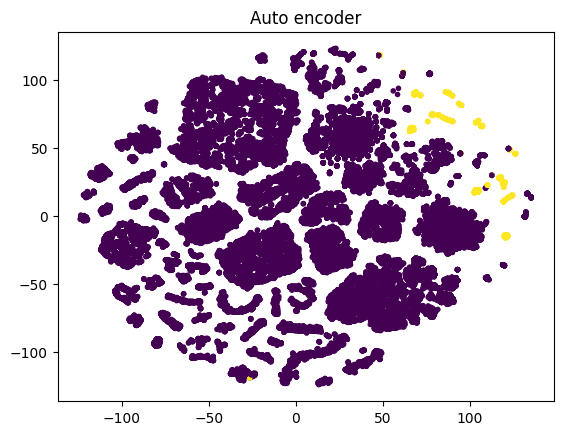

In [ ]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=viz_y[index], marker='.')
plt.title("Auto encoder")